In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [1]:
!ls '/kaggle/input/optiver-trading-at-the-close'

example_test_files  optiver2023  public_timeseries_testing_util.py  train.csv


#### Q1: Anomalies and Cleaning, 15 pts

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Here, the `df` variable stores the entire dataframe.

In [3]:
df.head(1)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,0_0_0


In [4]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

Checking for NULL values. Here, `far_price` and `near_price` are NULL because they aren't reported by the index for `seconds_in_bucket` values less that 240. Moreover, there is a suspicious pattern here - a lot of columns are NULL at exactly 220 places. This might suggest there are a specific set of rows that have all of these fields set to NULL - let's check this.

In [5]:
df[df['wap'].isnull()].head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
370468,131,35,50,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1930,35_50_131
370660,131,35,60,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1931,35_60_131
370852,131,35,70,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1932,35_70_131
371044,131,35,80,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1933,35_80_131
371236,131,35,90,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1934,35_90_131


Our expectations were probably true - it seems to be the case that for a subset of rows, a lot of columns are simulataneously NULL.

In [6]:
# Sort the DataFrame 'df' by multiple columns in the specified order
# The sorting order is first by 'stock_id', then by 'date_id', and finally by 'time_id'
# The 'inplace=True' parameter means the DataFrame is modified directly, and no new DataFrame is created
df.sort_values(['stock_id', 'date_id', 'time_id'], inplace=True)

Sorting the dataframe by `stock_id`, `date_id` and `time_id` - this would make it convenient for bfill and ffill being used for cleaning later on.

In [11]:
def handleMissingData(df, fillMethod):
    # Create an empty dictionary to store date_id for each stock with missing reference_price
    stockDateMap = {}

    # Create a copy of the df containing rows where reference_price is null
    nullDF = df[df.reference_price.isnull()].copy()

    # Get unique stockIDs with missing reference_price
    stockIds = df[df.reference_price.isnull()]['stock_id'].unique()

    # For each unique stockID, determine the date_id with missing reference_price
    for stockID in stockIds:
        stockDateMap[stockID] = nullDF[nullDF['stock_id'] == stockID].date_id.unique()[0]

    # Depending on the fillMethod:
    if (fillMethod == 0):
        # List of columns to modify when filling missing data
        columnsToBeModified = ['imbalance_size', 'matched_size', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'far_price', 'near_price', 'target', 'reference_price', 'wap']

        # Iterate through each stock with missing reference_price
        for stockID in stockDateMap.keys():

            # Create masks for the current and previous date_ids
            currentMask = (df['stock_id'] == stockID) & (df['date_id'] == stockDateMap[stockID])
            previousMask = (df['stock_id'] == stockID) & (df['date_id'] == stockDateMap[stockID] - 1)

            # Iterate over timestamps (seconds_in_bucket)
            for timestamp in range(0, 541, 10):
                # For each column, fill missing values in the current date_id using the previous date_id's value
                for column in columnsToBeModified:
                    df.loc[currentMask & (df['seconds_in_bucket'] == timestamp),
                    column] = df.loc[previousMask & (df['seconds_in_bucket'] == timestamp), column].values[0]

    elif (fillMethod == 1):
        # List of columns to modify when filling missing data
        columnsToBeModified = ['imbalance_size', 'matched_size', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'far_price', 'near_price', 'target', 'reference_price', 'wap']

        # Iterate through each stock with missing reference_price
        for stockID in stockDateMap.keys():

            # Create masks for the current, previous, and next date_ids
            currentMask = (df['stock_id'] == stockID) & (df['date_id'] == stockDateMap[stockID])
            previousMask = (df['stock_id'] == stockID) & (df['date_id'] == stockDateMap[stockID] - 1)
            nextMask = (df['stock_id'] == stockID) & (df['date_id'] == stockDateMap[stockID] + 1)

            # Iterate over timestamps (seconds_in_bucket)
            for timestamp in range(0, 541, 10):
                # For each column, fill missing values in the current date_id using the mean of the previous and next date_id's values
                for column in columnsToBeModified:
                    df.loc[currentMask & (df['seconds_in_bucket'] == timestamp),
                    column] = np.mean([df.loc[previousMask & (df['seconds_in_bucket'] == timestamp), column].values[0],
                                        df.loc[nextMask & (df['seconds_in_bucket'] == timestamp), column].values[0]])

        # If 'wap' is in the columnsToBeModified, calculate the Weighted Average Price
        if 'wap' in columnsToBeModified:
            df['wap'] = df.apply(lambda x: (x['ask_price'] * x['bid_size'] + x['bid_price'] * x['ask_size']) / (x['bid_size'] + x['ask_size']), axis=1)

    # Return the updated df with missing data filled
    return df

In [12]:
# Calling the handleMissingData function and storing the rectified dataframe back in df
df = handleMissingData(df, 1)

All the 220 null values are for 4 specific stocks (19, 101, 131, 158) for one day each. To impute them, simple bfill or ffill would not work. Instead, we need to impute for time ti on the null-values day d with the corresponding value at ti on the day d - 1 and / or d + 1 (either bfill, ffill or average of the two), for each stock. 

**The main reason for this averaging is to retain the (expected) autocorrelated nature for each of these variables. Average of next and previous values is more 'curve-friendly' than simple bfill or ffill.**

In [13]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894242
near_price                 2857080
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

Thus, we have removed all NULL values. The only NULL values that remain are the `far_price` and `near_price`. We will deal with them in the following manner - if `seconds_in_bucket` is ≤ 300, then we imput NULL with 0. Otherwise, we impute it as the average of previous and next values.

In [14]:
# Create a condition to filter rows where the 'seconds_in_bucket' column is less than or equal to 300
secondsInBucketCondition = (df['seconds_in_bucket'] <= 300)

# Create a condition to filter rows where the 'far_price' column is missing (NaN)
farPriceCondition = (df['far_price'].isna())

# Create a condition to filter rows where the 'near_price' column is missing (NaN)
nearPriceCondition = (df['near_price'].isna())

# For rows that satisfy both conditions (seconds_in_bucket <= 300 and far_price is missing), 
# set the 'far_price' value to 0
df.loc[secondsInBucketCondition & farPriceCondition, 'far_price'] = 0

# For rows that satisfy both conditions (seconds_in_bucket <= 300 and near_price is missing), 
# set the 'near_price' value to 0
df.loc[secondsInBucketCondition & nearPriceCondition, 'near_price'] = 0

The `secondsInBucketCondition` is used to specify that the setting-NULL-to-0 operation is only being applied to rows with `seconds_in_bucket` <= 300. Further, `farPriceCondition` and `nearPriceCondition` are, respectively, used to mention the application of setting-to-0 operation only to rows where the values of `far_price` and `near_price` are NULL. Otherwise, we would lose out on correct data.

In [15]:
df.isnull().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  32881
near_price                     0
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
time_id                        0
row_id                         0
dtype: int64

Even after the earlier imputation, we still find that there are rows where `far_price` is NULL. These rows are the ones where `seconds_in_bucket` is actually > 300 (meaning the values are expected to be present), but they're not. So, we will impute them with the previous value for `far_price`, when the dataframe is sorted according to `stock_id`, `date_id` and `time_id`.

In [16]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,0.0,0.0,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,0.0,0.0,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,0.0,0.0,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,0.0,0.0,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0


In [17]:
# For all the remaining far_price values that are set to NULL, we use forward fill technique
df['far_price'] = df['far_price'].fillna(method='ffill')
df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

There is another issue. Here, there are multiple stocks that do not have data for all the days present. This can be easily verified using the following command:

In [18]:
# Create an empty set to store unique 'row_id' values from the DataFrame 'df'
uniqueRowIDs = set(df['row_id'])

# Create an empty set to store stock IDs with missing days
stocksWithMissingDays = set()

# Iterate through possible combinations of 'i', 'j', and 'k' within specified ranges
for i in range(0, 481):
    for j in range(0, 55):
        for k in range(0, 200):
            # Create a string 'rowValue' based on the current combination
            rowValue = f'{i}_{j * 10}_{k}'

            # Check if 'rowValue' is not in the set of unique 'row_id' values
            if rowValue not in uniqueRowIDs:
                # If 'rowValue' is not found in the DataFrame, add 'k' to the set of stock IDs with missing days
                stocksWithMissingDays.add(k)

# Print the set of stock IDs with missing days
print(stocksWithMissingDays)

{99, 69, 102, 135, 199, 73, 78, 79, 150, 153, 156}


This piece of code loops over each `date_id`, for each `time_id`, for each `stock_id` and finds out all the days where data for certain dates is absent. Finding this out is important for Q4, where we transform the dataframe in such a way that each row represents one unique day in the stock market and records the up / down days for every stock. If a stock does not have the data for a given day, it is going to hold NULL values, which is not what we want, especially if we're doing a significance test. 

#### Q2: Pairwise Corralation Table and Explanation. 10 pts

In [19]:
# Calculate the Pearson correlation matrix for the DataFrame 'df'
# The Pearson correlation measures linear relationships between numeric columns
# and quantifies the strength and direction of the linear association between variables
correlationMatrix = df.corr(method='pearson')

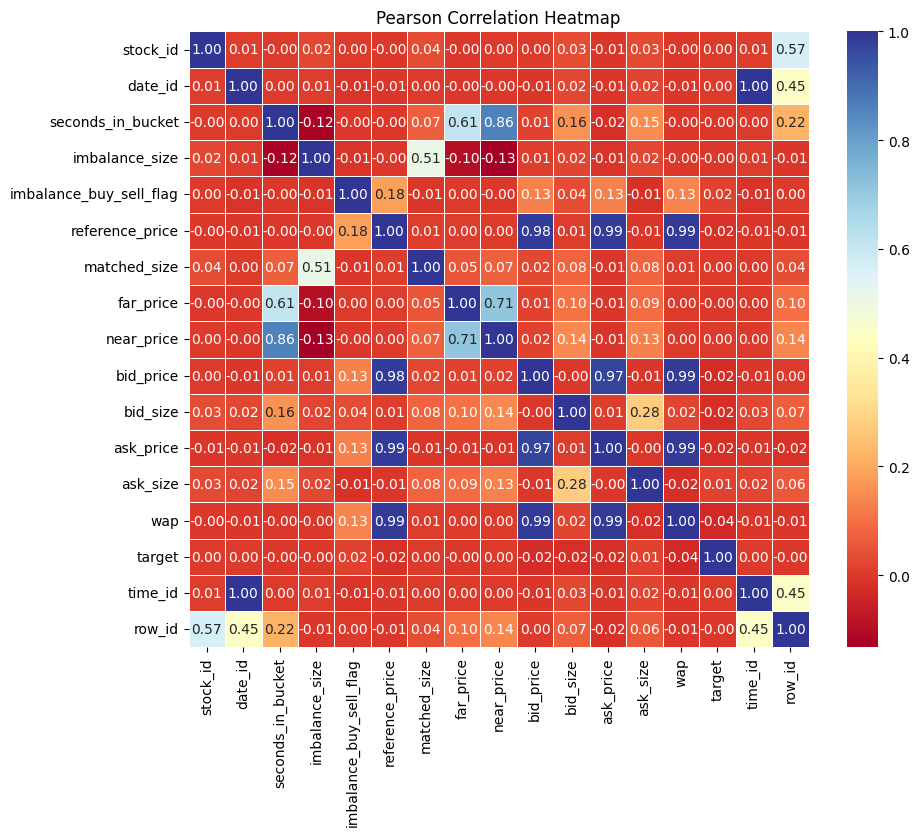

In [20]:
# Create a figure with a specific size (10 inches in width and 8 inches in height)
plt.figure(figsize=(10, 8))

# Create a heatmap of the Pearson correlation matrix
# - 'correlationMatrix' is the matrix of Pearson correlation coefficients between variables.
# - 'annot=True' displays the actual correlation values on the heatmap.
# - 'cmap='RdYlBu'' specifies the colormap to use for color-coding the values.
# - 'fmt=".2f"' formats the displayed values as two decimal places.
# - 'linewidths=.5' adds grid lines to separate the cells in the heatmap.
sns.heatmap(correlationMatrix, annot=True, cmap='RdYlBu', fmt=".2f", linewidths=.5)

# Set the title of the heatmap
plt.title('Pearson Correlation Heatmap')

# Show the heatmap
plt.show()

Reasons for high correlation values:

1. **reference_price** and **bid_price**: a high positive correlation exists between these two columns. It is positive because the bid price for a stock can only be ≥ its reference price. Further, a high absolute value of the correlation might suggest that a bidder is not likely to go much higher than what most people believe is a fair prrice for the stock (which is represented by the reference_price).

2. **wap** and **ask_price**, **wap** and **bid_price**: weighted average price is simply a linear combination of **ask_price** and **bid_price**, given by:
>
> `wap = (bid_price * ask_size + bid_size * ask_price) / (bid_size + ask_size)`
>
As a result of this linear combination, the value of "wap" exhibits a lot of correlation with bid_price and ask_price. Note that if we were using a regression model, it would probably not be wise to include all three of these features at the same time, as regression models require as low multicollinearity between different independent variables as possible so as to obtain a good result, and a high correlation often indicates high multicollinearity. Since wap is highly positively correlated with bid_price and ask_price, it is also highly correlated with reference_price. It can be thought of as a cluster of correlation, between wap, bid_price, ask_price, reference_price.

3. **far_price** and **near_price**: these two columns are significantly correlated because they are, for most rows, simultaneously NULL whenever seconds_in_bucket is less than or equal to 240, and during the imputation process, they're both imputed with 0s. Thus, for more than half of the rows, their values are identical and go hand-in-hand.

4. Every column is correlated with itself - this is trivial.

5. **seconds_in_bucket** and **far_price / near_price**: there could be a temporal relationship between these columns, meaning as time progresses during the auction, the market participants have more information and trading activity occurring, which can impact the determination of the closing price. Both far_price and near_price are reference prices used in relation to the closing auction, and they are influenced by the trades that occur over time.

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts

In [ ]:
csv.describe()

In [ ]:
csv.head(1)

In [ ]:
average_records = csv.groupby(['stock_id', 'date_id']).agg({
    'seconds_in_bucket': 'mean',
    'imbalance_size': 'mean',
    'imbalance_buy_sell_flag': 'mean',
    'reference_price': 'mean',
    'matched_size': 'mean',
    'bid_price': 'mean',
    'bid_size': 'mean',
    'ask_price': 'mean',
    'ask_size': 'mean',
    'wap': 'mean',
    'target': 'mean',
    'time_id': 'count'  # You can change this depending on your needs
}).reset_index()

In [ ]:
average_records.shape

In [ ]:
average_records.head()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Sort the data by 'stock_id', 'date_id', and 'time_id' in ascending order
csv.sort_values(by=['stock_id', 'date_id', 'time_id'], inplace=True)

# Group data by 'stock_id' and 'date_id' and select the last record for each group
# last_records = csv.groupby(['stock_id', 'date_id']).last().reset_index()

In [ ]:
csv = csv.sort_values(by=['stock_id', 'date_id', 'time_id'])

# Define the number of days to look back and ahead (10 in this case).
look_back_days = 10
look_ahead_days = 10

# Create an empty DataFrame to store the autocorrelation results.
autocorrelation_results = pd.DataFrame(columns=['stock_id', 'autocorrelation'])

# Group the data by 'stock_id'.
grouped = df.groupby('stock_id')

# Iterate through each group (stock_id).
for stock_id, group in grouped:
    # Calculate autocorrelation for each 'target' value in the group.
    autocorrelations = []
    for i in range(-look_back_days, look_ahead_days + 1):
        autocorrelation = group['target'].autocorr(lag=i)
        autocorrelations.append(autocorrelation)

    # Create a DataFrame for the results and append it to the main results DataFrame.
    stock_autocorr_df = pd.DataFrame({'stock_id': [stock_id] * (2 * look_back_days + 1), 'autocorrelation': autocorrelations})
    autocorrelation_results = autocorrelation_results.append(stock_autocorr_df, ignore_index=True)

# Print or save the autocorrelation results.
print(autocorrelation_results)

In [ ]:
len(autocorrelation_results.keys())

In [ ]:
print(len(sig), len(non_sig))

In [ ]:
len(csv['stock_id'].unique())

In [ ]:
csv.head()

In [ ]:
csv_stockwise = {}
unique_stocks = csv['stock_id'].unique()
for stock in unique_stocks:
    csv_stockwise[stock] = csv[csv['stock_id'] == stock]

In [ ]:
plt.figure(figsize=(11,4), dpi= 80)
pd.plotting.autocorrelation_plot(csv_stockwise[0].loc[:, 'bid_price'])

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts

Here, I have created a new dataframe called q4_df, which contains aggregated values of each row and is grouped by `stock_id` and `date_id`. Note that generally every numerical value is aggregated as **mean**, except for `reference_price`, which is aggregated as product. This is because actually the `reference_price` column is a ratio of the new reference price (in terms of absolute value) to the old reference price (in terms of absolute value), rather than the actual absolute value. Thus, a more accurate estimation of the eventual reference price at the end of the day would be the product of all reference prices and not simply the arithmetic mean. The same is also true for `bid_price`.

In [21]:
q4_df = df.groupby(['stock_id', 'date_id']).agg({
    'seconds_in_bucket': 'mean',
    'imbalance_size': 'mean',
    'imbalance_buy_sell_flag': 'mean',
    'reference_price': 'prod',
    'matched_size': 'mean',
    'bid_price': 'prod',
    'bid_size': 'mean',
    'ask_price': 'prod',
    'ask_size': 'mean',
    'wap': 'mean',
    'target': 'mean',
    'time_id': 'count'  # You can change this depending on your needs
}).reset_index()

In [22]:
q4_df = q4_df[~q4_df['stock_id'].isin(stocksWithMissingDays)]

In [23]:
q4_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64

Below, I have created a new dataframe called perf_df (short for performance dataframe). This dataframe stores each stock's aggregated performance for every single day - for this, it considers the reference price values. If at the end of the day, the reference price value is > 1, the stock will store its performance for that day as +1, else -1. Eventually, we will get a dataframe with a collection of +1's and -1's.

##### 4b. Good days vs. bad days.

In [24]:
perf_df = pd.DataFrame()
q4_df["row_number"] = q4_df.groupby("date_id").cumcount() + 1
perf_df = q4_df.pivot(index='date_id', columns='row_number', values=['reference_price'])
perf_df.columns = [f'stock_{stock_id}' for stock_id in q4_df['stock_id'].unique()]
perf_df.reset_index(inplace=True)

In [25]:
perf_df.head(5)

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198
0,0,0.981676,0.980665,0.975142,0.972667,0.959123,1.066424,1.018245,0.957461,0.937763,...,1.093058,1.070061,1.164560,0.938123,1.003088,0.964803,0.970614,0.976426,0.989290,1.012147
1,1,0.949057,1.013241,1.028246,0.990507,1.083755,1.124239,1.019209,1.062784,1.002415,...,0.982872,0.979526,0.987466,1.035821,1.106003,1.228496,1.002279,0.960323,1.039529,0.997516
2,2,0.943330,0.816405,0.971594,0.993642,0.897965,0.992049,1.006411,1.047231,0.854475,...,0.977736,0.875654,0.982164,1.063471,1.034076,0.983915,0.946070,0.976866,1.054993,0.990386
3,3,0.940381,1.170528,1.051236,0.976517,1.007361,1.023666,0.900020,1.038102,1.010036,...,1.032623,1.064633,1.013655,1.033913,1.047087,1.139446,1.053194,1.017672,1.046020,0.994901
4,4,1.038598,1.072566,1.104198,1.013751,1.122115,0.948031,0.974695,1.099928,1.155052,...,0.975662,0.942585,0.974158,1.058170,1.094019,1.132269,0.930090,0.992498,1.007910,1.022006


In [26]:
for col in perf_df.columns:
    if col != 'date_id':
        perf_df[col] = perf_df[col].apply(lambda x : 1 if x > 1 else -1)

In [27]:
perf_df.head()

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198
0,0,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,1,-1,1,-1,-1,-1,-1,1
1,1,-1,1,1,-1,1,1,1,1,1,...,-1,-1,-1,1,1,1,1,-1,1,-1
2,2,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,-1,1,1,-1,-1,-1,1,-1
3,3,-1,1,1,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,1,-1
4,4,1,1,1,1,1,-1,-1,1,1,...,-1,-1,-1,1,1,1,-1,-1,1,1


The main reason to convert the performances from reference price values to +1's and -1's was to easily aggregate each day's market performance as simply the sum of all individual stock performances on that day.
1. If the day was a neutral day, the overall mean would be close to 0.
2. If it was an exceptionally good day, the overall mean would be significantly greater than 0.
3. If it was an exceptionally bad day, the overall mean would be significantly lesser than 0.

In [28]:
stockColumns = [col for col in perf_df.columns]
stockColumns.remove('date_id')
perf_df['total']= perf_df[stockColumns].sum(axis=1)

/tmp/ipykernel_437/1504577908.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  perf_df['total']= perf_df[stockColumns].sum(axis=1)


Here, the `stockColumns` variable is a list of all columns that need to be summed up so as to get a score on how the market performs for a given day - basically, it contains a list of all the stocks we are considering to judge the market performance on a given day. This sum is stored inside the `total` column.

In [29]:
perf_df.head()

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,total
0,0,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,1,-1,-1,-1,-1,1,-9
1,1,-1,1,1,-1,1,1,1,1,1,...,-1,-1,1,1,1,1,-1,1,-1,7
2,2,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,1,1,-1,-1,-1,1,-1,-89
3,3,-1,1,1,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,-1,91
4,4,1,1,1,1,1,-1,-1,1,1,...,-1,-1,1,1,1,-1,-1,1,1,49


As we can see, the dataframe perf_df is a simple collection of +1's and -1's, for the most part (now appended with the 'total' column as well).

In [30]:
referenceDate = None
neutralScore = perf_df['total'].max()
for index, row in perf_df.iterrows():
    if abs(row['total']) < neutralScore:
        neutralScore = abs(row['total'])
        referenceDate = row['date_id']
print(f"Here, the reference date for the permutation test is: {referenceDate}, where the absolute value of 'total' is {neutralScore}.")
referenceMarketState = perf_df[perf_df['date_id'] == referenceDate][stockColumns].iloc[0].values.tolist()

Here, the reference date for the permutation test is: 5, where the absolute value of 'total' is 1.


Now, we will do 2 statistic tests that give us the same general results - there are both bad days and good days in the market, and overall, in the given population, there are more bad days than good.

1. Permutation test

For this, we consider a row with a value of mean as close to 0 as possible - in this case, it is the row with date_id = 5. Now, considering this as a reference for all other dates, we try to determing if other days have means as close to this reference day as possible. If they don't, they belong to one of either categories - positive or negative.

In [31]:
# Import necessary libraries and suppress runtime warnings
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation.")

# Initialize empty lists to store results
positiveMarketDays = []
negativeMarketDays = []

# Set the significance level for the test (e.g., 0.05 for a 95% confidence interval)
significanceLevel = 0.05

# Iterate over unique dates in the DataFrame 'perf_df'
for date in perf_df['date_id'].unique():
    # Extract the data for the current date and the reference market state
    dist = perf_df[perf_df['date_id'] == date][stockColumns].values.flatten().tolist()
    
    # Calculate the observed difference in means between the current date's data and the reference market state
    observedDifference = np.mean(dist) - np.mean(referenceMarketState)
    
    # Specify the number of permutations for the test
    numberOfPermutations = 10000
    
    # Initialize an array to store permuted differences
    permutedDifferences = np.zeros(numberOfPermutations)
    
    # Combine the data for the current date and the reference market state
    combinedPopulation = np.concatenate((dist, referenceMarketState))
    
    # Perform the permutation test with a loop
    for i in range(numberOfPermutations):
        # Randomly shuffle the combined population, generating an artificial time series
        np.random.shuffle(combinedPopulation)

        # Compute the permuted means for each group
        permutedMean1 = np.mean(combinedPopulation[:len(dist)])
        permutedMean2 = np.mean(combinedPopulation[len(referenceMarketState):])

        # Calculate the difference in means for this permutation
        permutedDifference = permutedMean1 - permutedMean2

        # Store the permuted difference in the array
        permutedDifferences[i] = permutedDifference

    # Calculate the p-value by comparing the observed difference to the null distribution of permuted differences
    pValue = (np.abs(permutedDifferences) >= np.abs(observedDifference)).mean()

    # Check if the p-value is less than half of the significance level and classify the market state for that date
    if pValue < significanceLevel / 2:
        if observedDifference >= 0:
            positiveMarketDays.append(date)
        else:
            negativeMarketDays.append(date)

In [32]:
print(f"{len(positiveMarketDays)} positive market days.")
print(f"{len(negativeMarketDays)} negative market days.")
print(f"{481 - len(positiveMarketDays) - len(negativeMarketDays)} neutral market days.")

156 positive market days.
175 negative market days.
150 neutral market days.


2. t-test

For this, we will consider every single date_id and determine whether the mean of that row is 0 or not. If it is statistically proven that it isn't the case for some days, then we will split those days into one of the two categories - positive or negative.

In [33]:
# Import necessary libraries and suppress runtime warnings
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation.")

# Initialize empty lists to store results
positiveMarketDays = []
negativeMarketDays = []

# Set the significance level for the test (e.g., 0.05 for a 95% confidence interval)
significanceLevel = 0.05

# Iterate over unique dates in the DataFrame 'perf_df'
for date in perf_df['date_id'].unique():
    # Extract the data for the current date and the reference market state
    dist = perf_df[perf_df['date_id'] == date][stockColumns].values.flatten().tolist()

    # Calculate the p-value and t-statistic for verifying whether the market state for the given date is good, bad or neutral
    tStatistic, pValue = stats.ttest_1samp(dist, 0)
    # Check if the p-value is less than half of the significance level and classify the market state for that date
    if pValue < significanceLevel / 2:
        if tStatistic >= 0:
            positiveMarketDays.append(date)
        else:
            negativeMarketDays.append(date)

In [34]:
print(f"{len(positiveMarketDays)} positive market days.")
print(f"{len(negativeMarketDays)} negative market days.")
print(f"{481 - len(positiveMarketDays) - len(negativeMarketDays)} neutral market days.")

179 positive market days.
203 negative market days.
99 neutral market days.


Both the tests, thus reveal the same thing. We have both statistically significant positive and negative (up and down) days in the market, with overall more negative days than positive.

##### 4a. Three plots

##### 1. Net stock performance vs. frequency

Text(0, 0.5, 'Frequency')

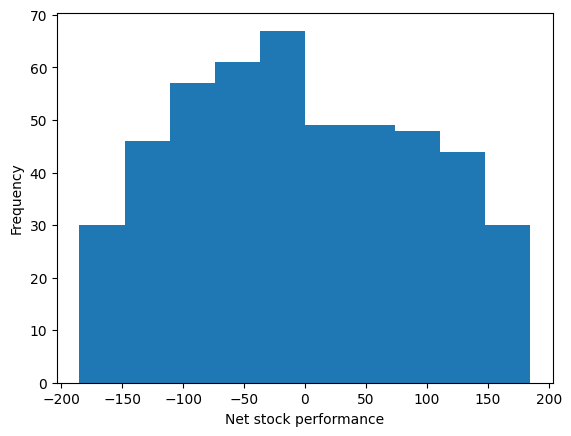

In [35]:
plt.hist(perf_df['total'])
plt.xlabel('Net stock performance')
plt.ylabel('Frequency')

This graph describes the net performance of all stocks for all days vs. frequency. The graph indicates a large volume of days experiencing stocks performing below average in a statistically significant manner. This is backed by our values of number of stocks performing well and number of stocks not performing well, as computed previously.

##### 2. Overall market performance during first 100 days to identify the bad days.

<Figure size 640x480 with 0 Axes>

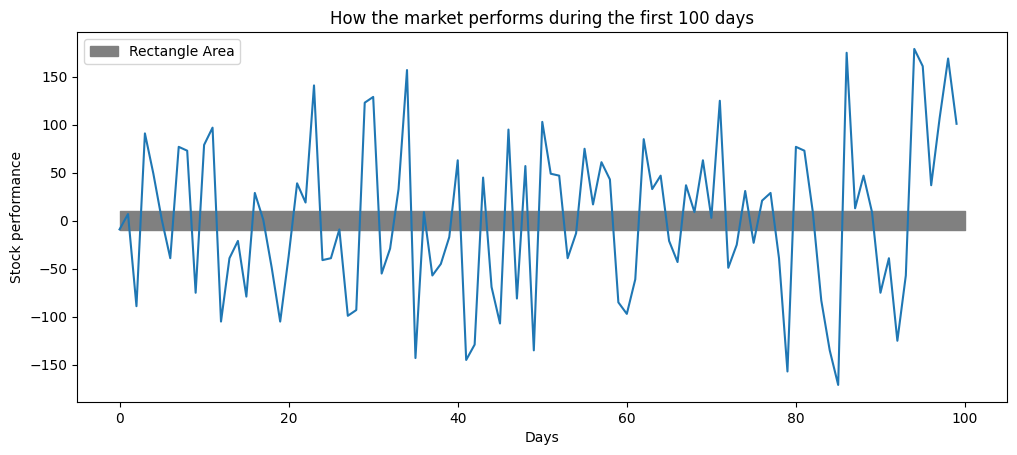

In [36]:
days = q4_df['date_id'].unique()[0:100]
y = perf_df['total'][0:100]
plt.figure(figsize=(12, plt.gcf().get_figheight()))
plt.plot(days, y, linestyle='-')
rect_start_x = 0
rect_end_x = 100
rect_bottom = -10
rect_top = 10
plt.fill_between([rect_start_x, rect_end_x], rect_bottom, rect_top, color='gray', alpha=1, label='Rectangle Area')
plt.xlabel('Days')
plt.ylabel('Stock performance')
plt.title('How the market performs during the first 100 days')
plt.legend()
plt.show()

For the first 100 days, the days when the stock market performs the worst (i.e deep troughs) occur at approximately regular intervals of 6 to 8 days, except for when no deep trough occurs between 60 and 80. Note that these deep troughs are only the worst performances for the stock market. There are of course other days between each successive deep troughs where the stock market performs bad in a statistically significant manner, but maybe not to the extent of these regularly occurring deep troughs. Although the visual confirmation may be misleading, one can see that overall in the graph, there are more bad days than good. This sample of the first 100 days displays similar results as the entire population (i.e there are more bad days than good). To approximate statistical significance, I have considered a window of "total" in the range [-10, 10] as being just good or bad 'by chance'.

#### Q5: Best prediction model, any approaches, 25 pts

In [41]:
def trainModel(modelName, model):
    independent_variables = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'bid_size', 'ask_size', 'wap']
    dependent_variable = 'target'
    X = df[independent_variables]
    y = df[dependent_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Training for {modelName} completed...")
    return {'name': modelName, model: model, 'score': mae}

In [44]:
models = []

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet

independent_variables = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'bid_size', 'ask_size', 'wap']
# independent_variables = ['wap']
dependent_variable = 'target'
X = df[independent_variables]
y = df[dependent_variable]
# tempo_df = df[~df['target'].isnan()]
model = xgb.XGBRegressor( objective='reg:squarederror', max_depth=3, n_estimators=100, learning_rate=0.1)
models.append(trainModel('XGBoost Regressor', model))

from sklearn.linear_model import Lasso
alpha = 0.1  # L1 regularization strength (adjust as needed)
model = Lasso(alpha=alpha, random_state=42)
models.append(trainModel('Lasso Regressor', model))

from sklearn.linear_model import LinearRegression
model = LinearRegression()
models.append(trainModel('Linear Regressor', model))

from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
models.append(trainModel('Ridge Regressor', model))

from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.01, l1_ratio=0.5)
models.append(trainModel('Elastic Net Regressor', model))

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)
model = LinearRegression()
models.append(trainModel('Polynomial Regressor', model))

Training for XGBoost Regressor completed...
Training for Lasso Regressor completed...
Training for Linear Regressor completed...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.45248e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training for Ridge Regressor completed...
Training for Elastic Net Regressor completed...
Training for Polynomial Regressor completed...


In [46]:
models

[{'name': 'XGBoost Regressor',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...): XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable

In [50]:
from operator import itemgetter
models = sorted(models, key=itemgetter('score'), reverse=False)
print(f"Best model for our dataframe is {models[0]['name']}, with an error score of {models[0]['score']} ")

Best model for our dataframe is XGBoost Regressor, with an error score of 6.333141245967041 


Thus, based on our model analysis, XGBoost model is the one thast performs the best, with the least value of Mean Absolute Error (MAE) ≈ 6.333

#### Q6: submit model on Kaggle, 0 pts
Public Score: \
Private Score: \
Kaggle profile link: \
Screenshot(s):
